In [1]:
import glob
import os
import itertools
import subprocess
import tempfile

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import umap
import logomaker
from ipywidgets import Dropdown, VBox
from IPython.display import display, clear_output
from python_pdb.aligners import align_pandas_structure
from python_pdb.formats.residue import THREE_TO_ONE_CODE
from python_pdb.parsers import parse_pdb_to_pandas

from tcr_pmhc_interface_analysis.imgt_numbering import assign_cdr_number
from tcr_pmhc_interface_analysis.processing import annotate_tcr_pmhc_df, find_anchors
from tcr_pmhc_interface_analysis.utils import get_coords

2024-05-14 12:07:43.496381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 12:07:43.643146: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-14 12:07:43.643212: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-14 12:07:44.750538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [2]:
DATA_DIR = '../data/processed/structure-pw-distances'

In [3]:
with open(os.path.join(DATA_DIR, 'structure_names.txt'), 'r') as fh:
    structure_names = [line.strip() for line in fh.readlines()]

In [4]:
df = pd.DataFrame()

for path in glob.glob(os.path.join(DATA_DIR, '*_distance_matrix.txt*')):
    name = os.path.basename(path).split('.')[0].replace('_distance_matrix', '')
    
    cdr, chain = name.split('_')
    
    cdr_distance_matrix = np.loadtxt(path)
    cdr_distance_matrix = np.maximum(cdr_distance_matrix, cdr_distance_matrix.transpose())
    
    cdr_clusters = hdbscan.HDBSCAN(min_cluster_size=5).fit_predict(cdr_distance_matrix)

    cdr_umap = umap.UMAP(metric='precomputed').fit_transform(cdr_distance_matrix)
    
    cdr_df = pd.DataFrame({
        'name': structure_names,
        'cluster': cdr_clusters,
        'umap_1': cdr_umap[:, 0],
        'umap_2': cdr_umap[:, 1],
    })
    cdr_df['chain_type'] = chain + '_chain'
    cdr_df['cdr'] = cdr.replace('cdr', '')
    
    df = pd.concat([df, cdr_df])

df

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be un

name  cluster     umap_1    umap_2   chain_type cdr
0    7zt2_DE        1  13.521075  2.100629   beta_chain   2
1    7zt3_DE        1  13.717066  1.969115   beta_chain   2
2    7zt4_DE        1  13.591029  2.073811   beta_chain   2
3    7zt5_DE        1  13.632319  2.068183   beta_chain   2
4    7zt7_DE        1  13.656903  2.029341   beta_chain   2
..       ...      ...        ...       ...          ...  ..
797  6miv_CD        7  15.822001  9.677701  alpha_chain   3
798  3rtq_CD        7  14.490083  9.842937  alpha_chain   3
799  3dxa_NO       12   4.313787  1.763012  alpha_chain   3
800  1d9k_AB       -1   3.157195  5.930483  alpha_chain   3
801  4gg6_GH       -1   4.420362  1.384732  alpha_chain   3

[4812 rows x 6 columns]

In [5]:
df['cluster'] = df['cluster'].apply(str)
df['cluster'] = df['cluster'].replace('-1', 'noise')

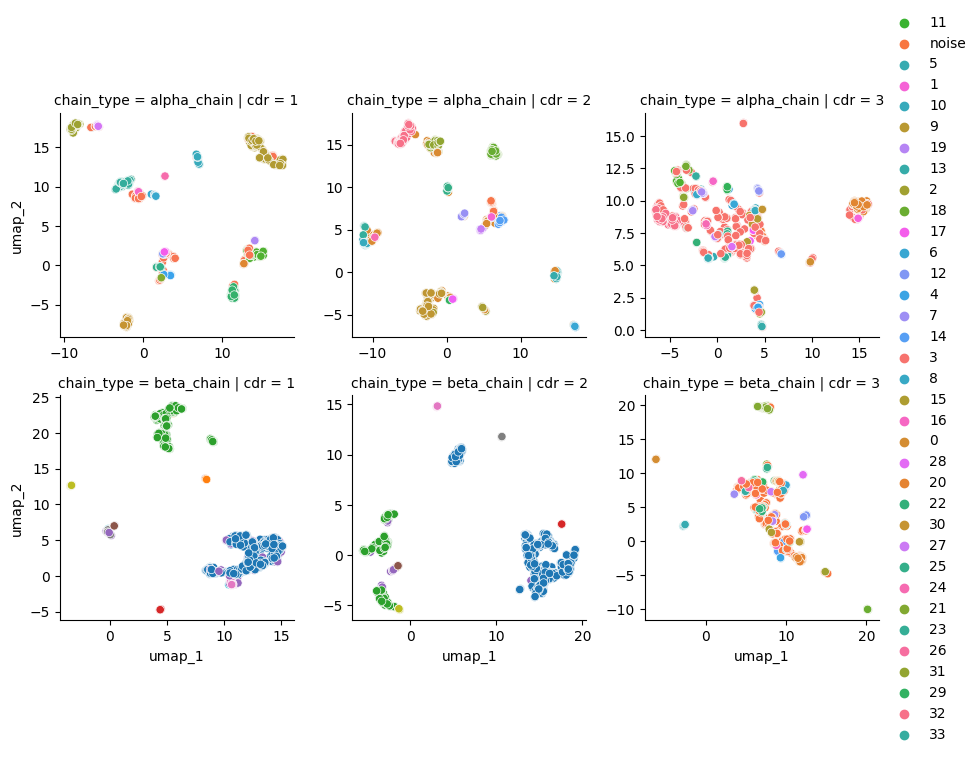

In [6]:
g = sns.FacetGrid(df.sort_values(['chain_type', 'cdr']), row='chain_type', col='cdr', sharex=False, sharey=False)
g.map(sns.scatterplot, 'umap_1', 'umap_2', 'cluster')
g.add_legend()

In [7]:
df.groupby(['chain_type', 'cdr'])['cluster'].value_counts()

chain_type   cdr  cluster
alpha_chain  1    10         184
                  noise      128
                  17          79
                  13          68
                  9           63
                            ... 
beta_chain   3    28           7
                  24           6
                  7            6
                  1            5
                  3            5
Name: cluster, Length: 127, dtype: int64

# Add sequences for each loop

In [8]:
structures = pd.DataFrame({
    'name': df['name'].unique(),
})

structures

name
0    7zt2_DE
1    7zt3_DE
2    7zt4_DE
3    7zt5_DE
4    7zt7_DE
..       ...
797  6miv_CD
798  3rtq_CD
799  3dxa_NO
800  1d9k_AB
801  4gg6_GH

[802 rows x 1 columns]

In [9]:
structures[['pdb_id', 'chains']] = structures['name'].str.split('_').apply(pd.Series)
structures[['alpha_chain_id', 'beta_chain_id']] = structures['chains'].apply(list).apply(pd.Series)

structures

name pdb_id chains alpha_chain_id beta_chain_id
0    7zt2_DE   7zt2     DE              D             E
1    7zt3_DE   7zt3     DE              D             E
2    7zt4_DE   7zt4     DE              D             E
3    7zt5_DE   7zt5     DE              D             E
4    7zt7_DE   7zt7     DE              D             E
..       ...    ...    ...            ...           ...
797  6miv_CD   6miv     CD              C             D
798  3rtq_CD   3rtq     CD              C             D
799  3dxa_NO   3dxa     NO              N             O
800  1d9k_AB   1d9k     AB              A             B
801  4gg6_GH   4gg6     GH              G             H

[802 rows x 5 columns]

In [10]:
def get_sequence(df):
    residue_names = df.drop_duplicates(['chain_id', 'residue_seq_id', 'residue_insert_code'])['residue_name']
    return ''.join(residue_names.map(THREE_TO_ONE_CODE).tolist())

In [11]:
def get_cdr_sequences(pdb_id, alpha_chain_id, beta_chain_id):
    with open(os.path.join('../data/raw/stcrdab', 'imgt', pdb_id + '.pdb'), 'r') as fh:
        structure_df = parse_pdb_to_pandas(fh.read())
    
    structure_df = annotate_tcr_pmhc_df(structure_df, alpha_chain_id, beta_chain_id)
    tcr_df = structure_df.query('chain_type.notnull()')
    
    cdr_sequences = tcr_df.groupby(['chain_type', 'cdr']).apply(get_sequence)
    cdr_sequences.name = 'sequence'
    
    index = cdr_sequences.index.to_flat_index()
    index = index.map(lambda index: f"cdr_{'a' if index[0] == 'alpha_chain' else 'b'}{int(index[1])}_sequence")
    cdr_sequences.index = index
    
    return cdr_sequences

In [12]:
structures = pd.concat([structures,
                        structures.apply(
                            lambda row: get_cdr_sequences(row.pdb_id, row.alpha_chain_id, row.beta_chain_id),
                            axis=1,
                        )],
                        axis=1)

structures

name pdb_id chains alpha_chain_id beta_chain_id cdr_a1_sequence  \
0    7zt2_DE   7zt2     DE              D             E          TSGFNG   
1    7zt3_DE   7zt3     DE              D             E          TSGFNG   
2    7zt4_DE   7zt4     DE              D             E          TSGFNG   
3    7zt5_DE   7zt5     DE              D             E          TSGFNG   
4    7zt7_DE   7zt7     DE              D             E          TSGFNG   
..       ...    ...    ...            ...           ...             ...   
797  6miv_CD   6miv     CD              C             D          VTPDNH   
798  3rtq_CD   3rtq     CD              C             D          VTPDNH   
799  3dxa_NO   3dxa     NO              N             O         TISGNEY   
800  1d9k_AB   1d9k     AB              A             B          DSTFDY   
801  4gg6_GH   4gg6     GH              G             H         TISGTDY   

    cdr_a2_sequence cdr_a3_sequence cdr_b1_sequence cdr_b2_sequence  \
0            NVLDGL      AFLDSNYQLI           MNHNY          SASEGT   
1            NVLDGL      AFLDSNYQLI           MNHNY          SASEGT   
2            NVLDGL      AFLDSNYQLI           MNHNY          SASEGT   
3            NVLDGL      AFLDSNYQLI           MNHNY          SASEGT   
4            NVLDGL      AFLDSNYQLI           MNHNY          SASEGT   
..              ...             ...             ...             ...   
797         LVDQKDK   VVGDRGSALGRLH           NNHNN          SYGAGS   
798         LVDQKDK   VVGDRGSALGRLH           NNHNN          SYGAGS   
799           GLKNN      IVWGGYQKVT           SEHNR          FQNEAQ   
800         ISLVSNK      AATGSFNKLT           NNHNN          SYGAGS   
801           GLTSN   ILRDGRGGADGLT           SGDLS          YYNGEE   

    cdr_b3_sequence  
0       ASSNREYSPLH  
1       ASSNREYSPLH  
2       ASSNREYSPLH  
3       ASSNREYSPLH  
4       ASSNREYSPLH  
..              ...  
797      ASGDEGYTQY  
798      ASGDEGYTQY  
799   ASRYRDDSYNEQF  
800     ASGGQGRAEQF  
801  ASSVAVSAGTYEQY  

[802 rows x 11 columns]

In [13]:
structures = structures.melt(id_vars=['name'],
                             value_vars=['cdr_a1_sequence',
                                         'cdr_a2_sequence',
                                         'cdr_a3_sequence',
                                         'cdr_b1_sequence',
                                         'cdr_b2_sequence',
                                         'cdr_b3_sequence'],
                            value_name='sequence')

In [14]:
structures[['chain_type', 'cdr']] = structures['variable'].map(lambda name: tuple(name.split('_')[1])).apply(pd.Series)
structures['chain_type'] = structures['chain_type'].map(lambda letter: 'alpha_chain' if letter == 'a' else 'beta_chain')

structures

name         variable        sequence   chain_type cdr
0     7zt2_DE  cdr_a1_sequence          TSGFNG  alpha_chain   1
1     7zt3_DE  cdr_a1_sequence          TSGFNG  alpha_chain   1
2     7zt4_DE  cdr_a1_sequence          TSGFNG  alpha_chain   1
3     7zt5_DE  cdr_a1_sequence          TSGFNG  alpha_chain   1
4     7zt7_DE  cdr_a1_sequence          TSGFNG  alpha_chain   1
...       ...              ...             ...          ...  ..
4807  6miv_CD  cdr_b3_sequence      ASGDEGYTQY   beta_chain   3
4808  3rtq_CD  cdr_b3_sequence      ASGDEGYTQY   beta_chain   3
4809  3dxa_NO  cdr_b3_sequence   ASRYRDDSYNEQF   beta_chain   3
4810  1d9k_AB  cdr_b3_sequence     ASGGQGRAEQF   beta_chain   3
4811  4gg6_GH  cdr_b3_sequence  ASSVAVSAGTYEQY   beta_chain   3

[4812 rows x 5 columns]

In [15]:
df = df.merge(structures[['name', 'chain_type', 'cdr', 'sequence']],
             how='left',
             on=['name', 'chain_type', 'cdr'])

# Adding cannonical conformation information to clusters

Based on the definition from [Comparative Analysis of the CDR Loops of Antigen Receptors](https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2019.02454/full), canonical clusters are any cluster where there are more than two unique sequences within the density clusters. The other clusters will be refered to as pseudo-clusters, as these may just be the effect of the same loop finding the same conformation.

In [16]:
cluster_types = df.query("cluster != 'noise'").groupby(
    ['chain_type', 'cdr', 'cluster'],
)['sequence'].agg(lambda sequences: 'canonical' if sequences.nunique() > 2 else 'pseudo')
cluster_types.name = 'cluster_type'

In [17]:
cluster_types[cluster_types == 'canonical'].reset_index().sort_values(['chain_type', 'cdr']).value_counts(['chain_type', 'cdr'])

chain_type   cdr
alpha_chain  3      19
beta_chain   3      18
alpha_chain  2      10
             1       8
beta_chain   1       5
             2       2
dtype: int64

In [18]:
df = df.merge(cluster_types.reset_index(), how='left', on=['chain_type', 'cdr', 'cluster'])

## Do the canonical clusters exist across different loop lengths?

In [19]:
df['cdr_length'] = df['sequence'].map(len)

In [20]:
df.groupby(['chain_type', 'cdr', 'cluster'])['cdr_length'].describe()

count       mean       std   min    25%   50%   75%  \
chain_type  cdr cluster                                                        
alpha_chain 1   0          7.0   5.000000  0.000000   5.0   5.00   5.0   5.0   
                1         53.0   7.000000  0.000000   7.0   7.00   7.0   7.0   
                10       184.0   6.000000  0.000000   6.0   6.00   6.0   6.0   
                11         9.0   6.000000  0.000000   6.0   6.00   6.0   6.0   
                12        37.0   6.000000  0.000000   6.0   6.00   6.0   6.0   
...                        ...        ...       ...   ...    ...   ...   ...   
beta_chain  3   6          8.0  13.500000  0.534522  13.0  13.00  13.5  14.0   
                7          6.0  12.833333  0.408248  12.0  13.00  13.0  13.0   
                8         10.0  13.700000  0.483046  13.0  13.25  14.0  14.0   
                9          8.0  12.000000  0.000000  12.0  12.00  12.0  12.0   
                noise    359.0  11.813370  1.879391   6.0  11.00  12.0  13.0   

                          max  
chain_type  cdr cluster        
alpha_chain 1   0         5.0  
                1         7.0  
                10        6.0  
                11        6.0  
                12        6.0  
...                       ...  
beta_chain  3   6        14.0  
                7        13.0  
                8        14.0  
                9        12.0  
                noise    18.0  

[127 rows x 8 columns]

Some clustering with different lengths!

# Visualizing the canonical cluster structures and sequences

## Sequence motifs for each canonical cluster

In [21]:
def format_fasta(group):
    index = group.index.tolist()
    sequence = group['sequence'].tolist()
    
    fasta = []
    
    for idx, sequence in zip(index, sequence):
        fasta.append(f'>{idx}\n{sequence}')
    
    return '\n'.join(fasta)

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


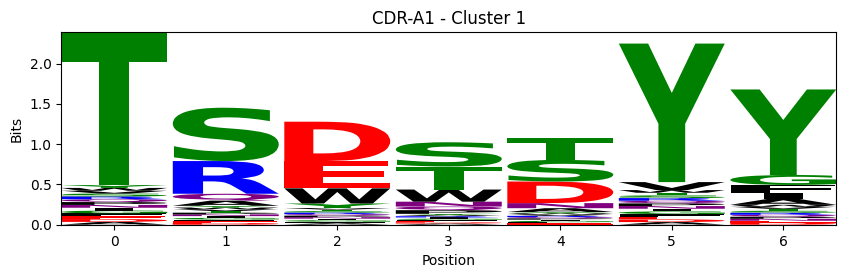

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


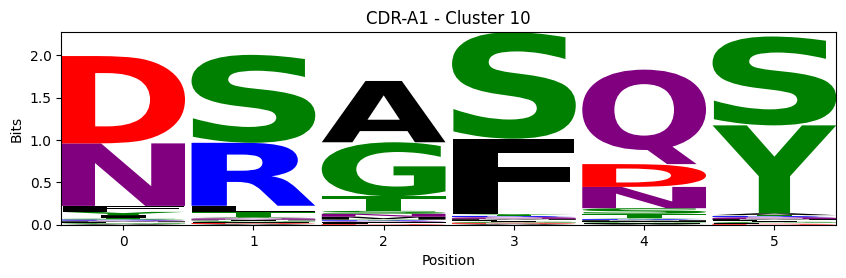

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


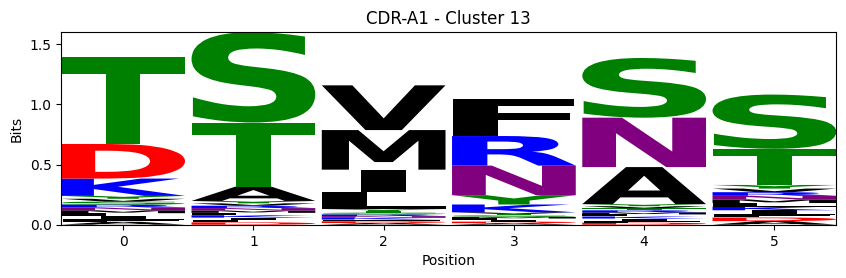

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


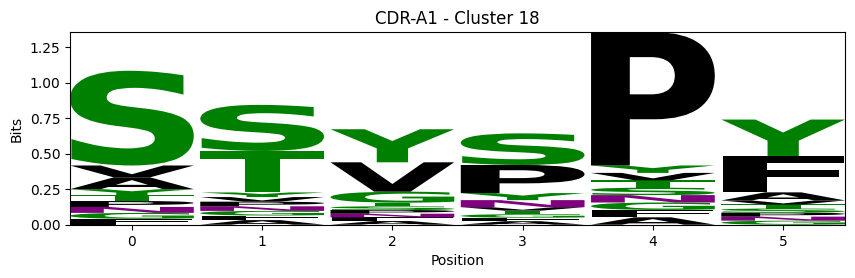

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


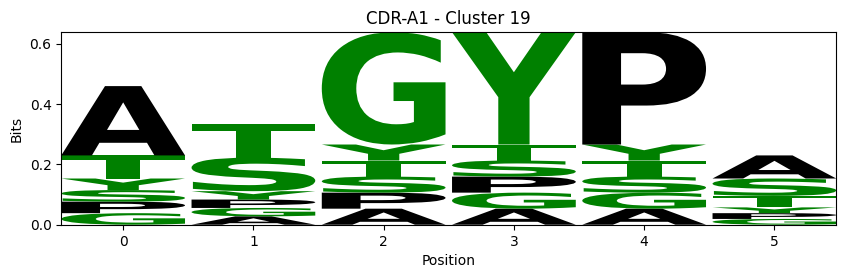

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


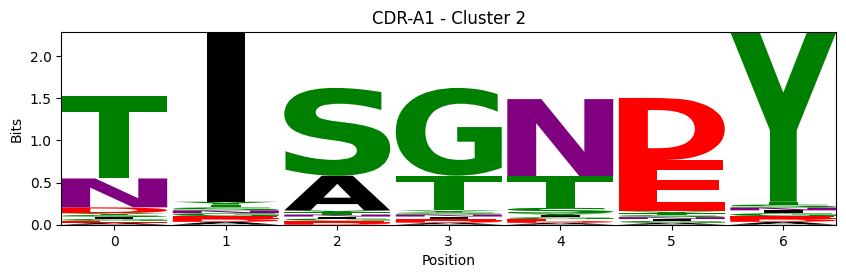

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


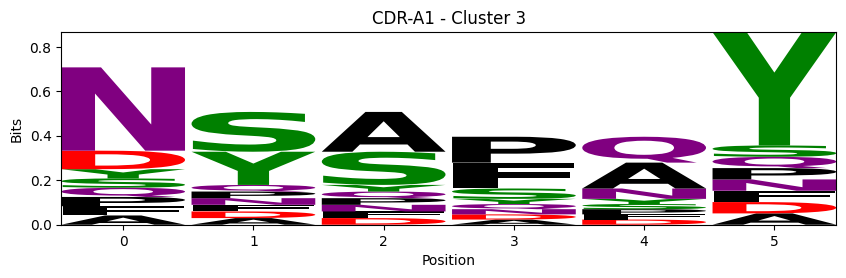

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


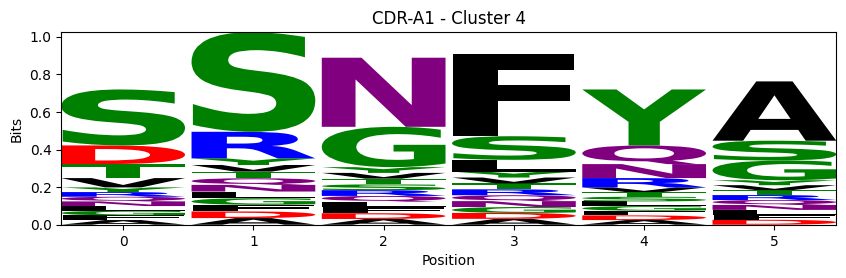

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


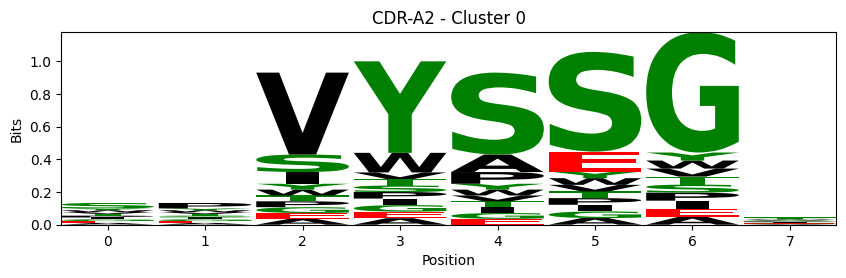

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


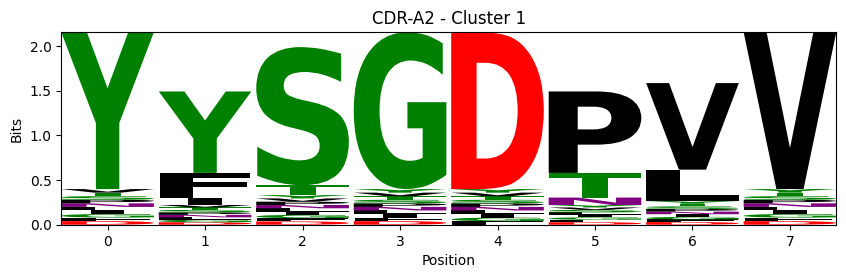

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


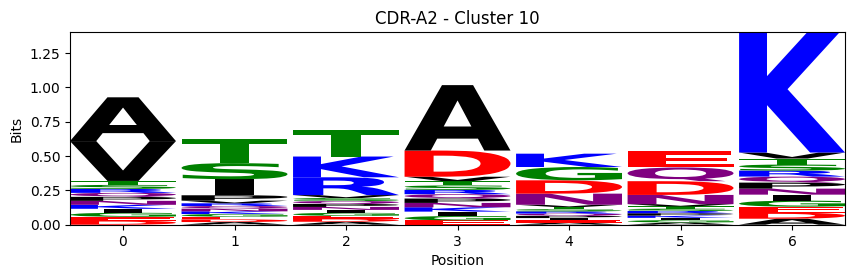

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


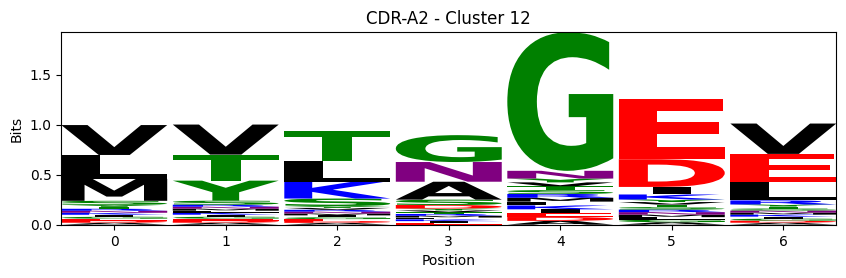

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


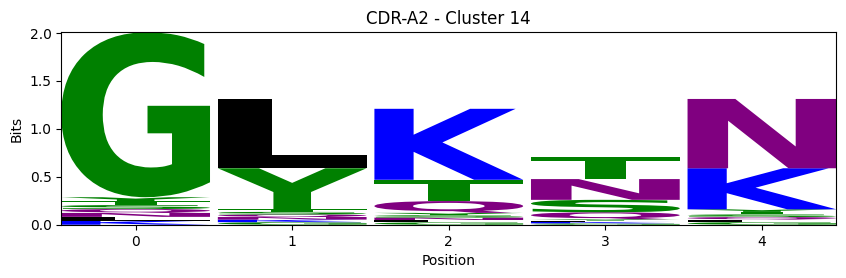

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


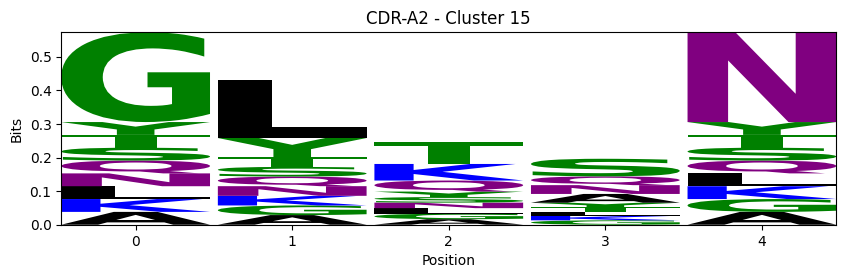

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


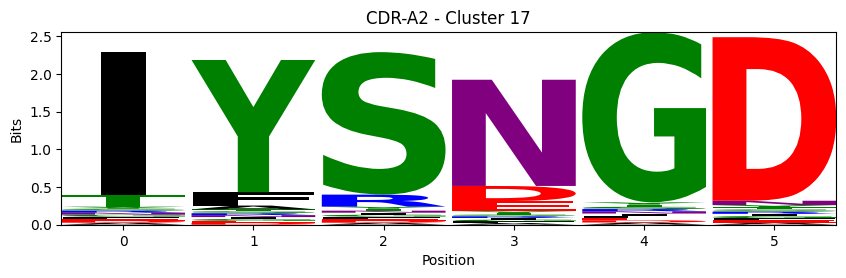

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


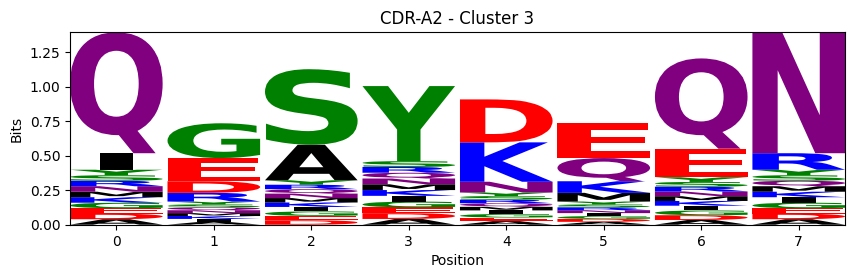

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


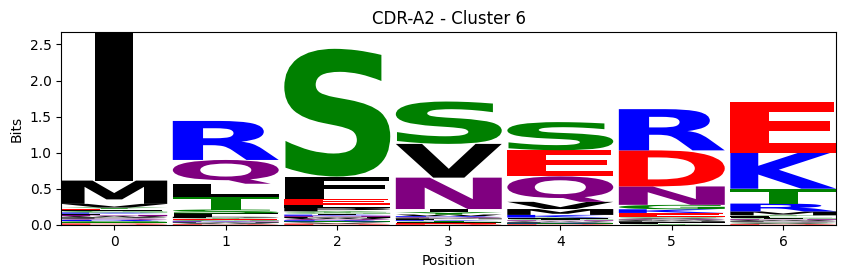

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


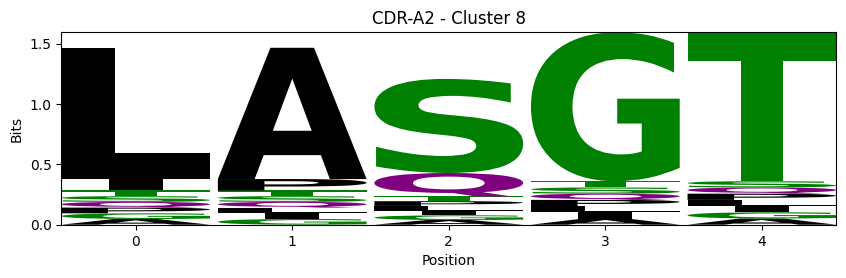

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


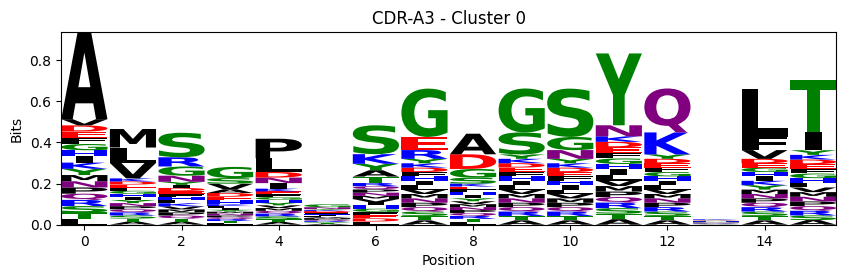

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


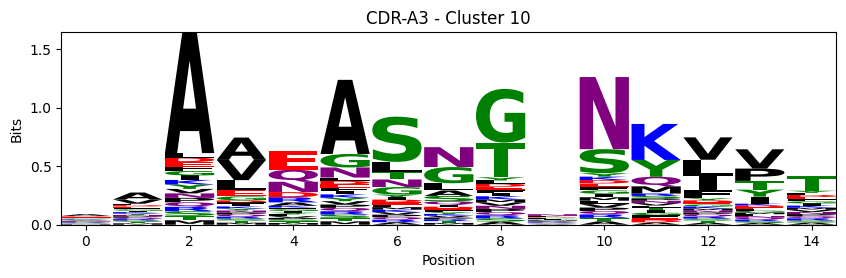

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


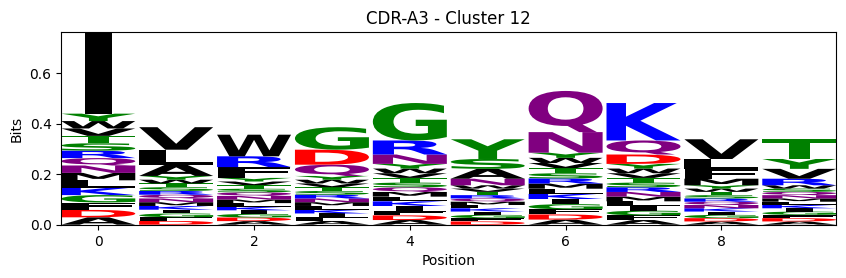

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


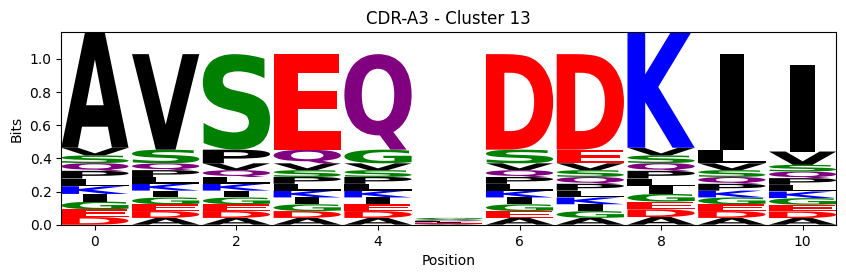

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


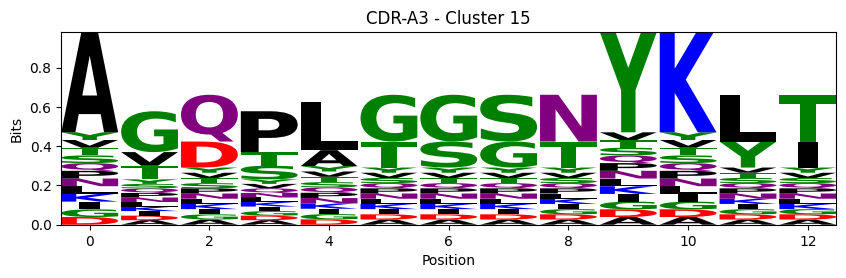

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


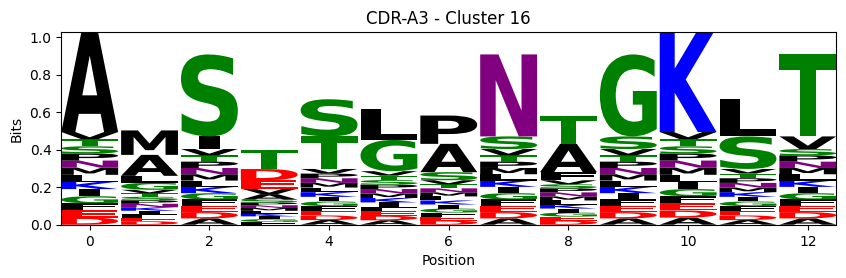

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


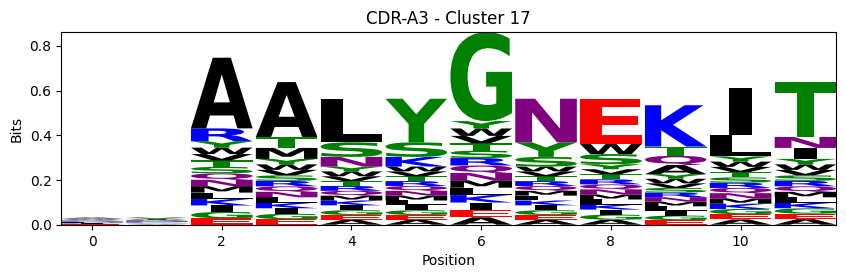

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


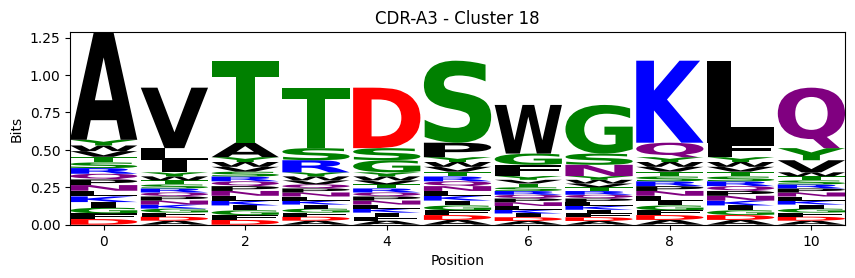

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


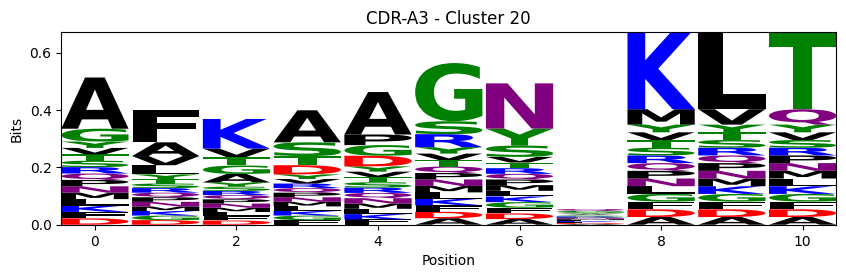

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


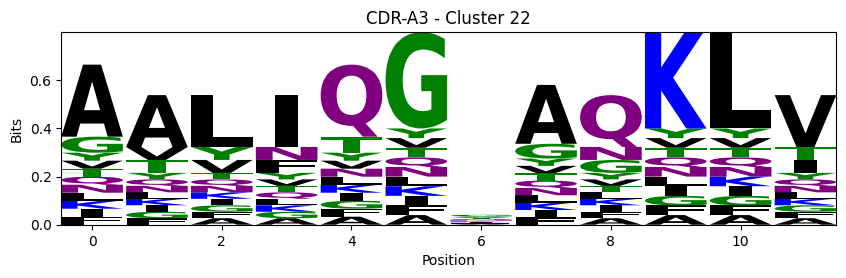

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


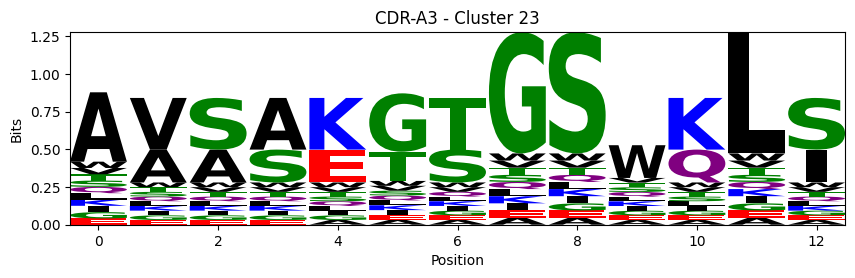

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


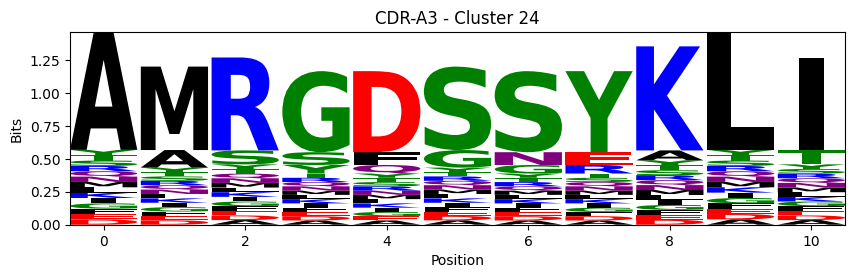

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


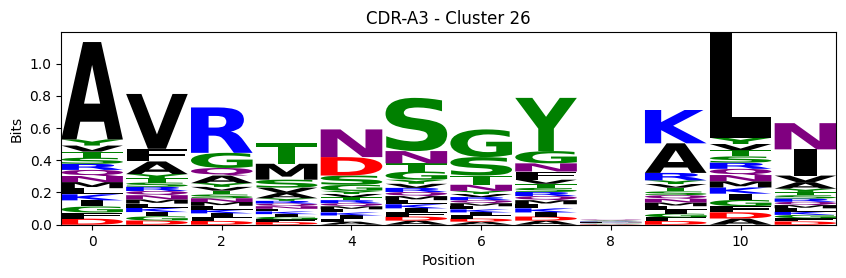

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


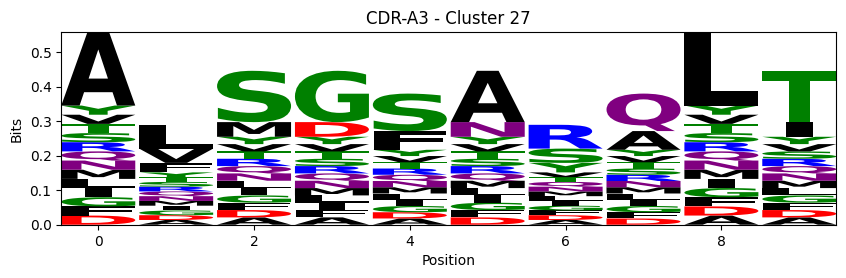

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


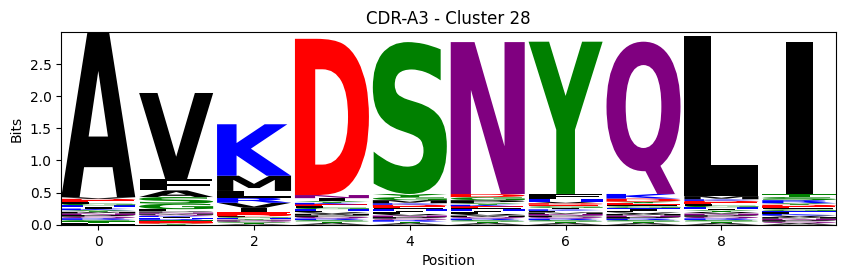

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


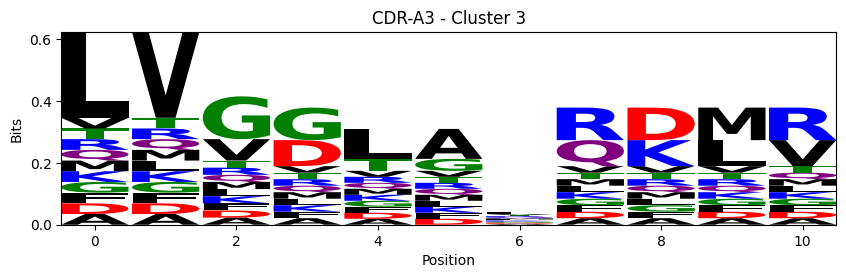

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


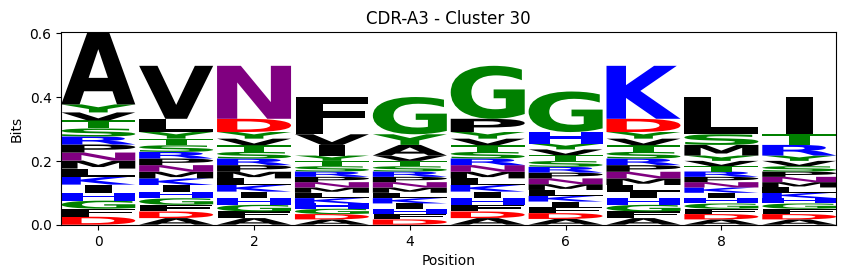

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


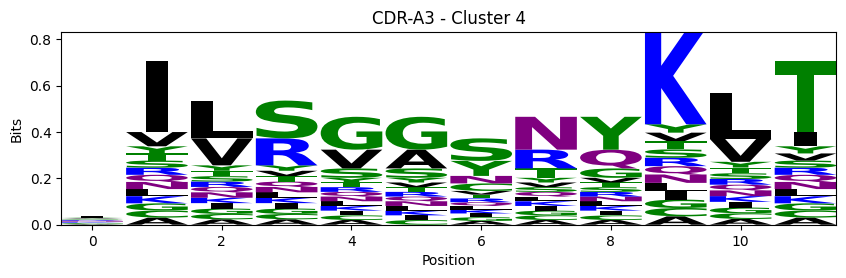

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


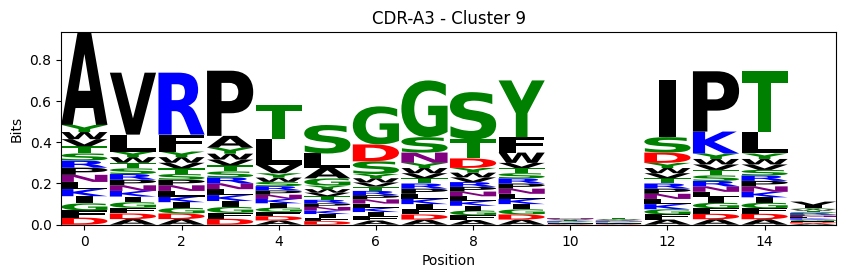

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


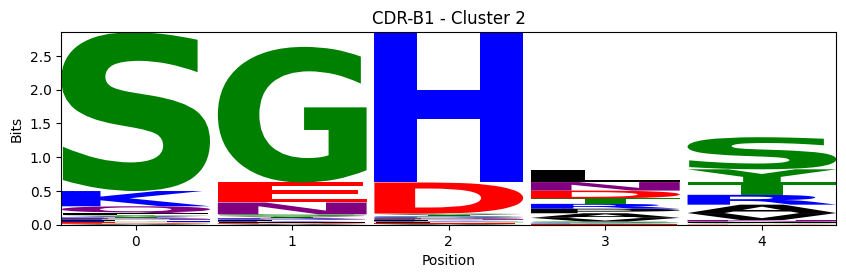

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


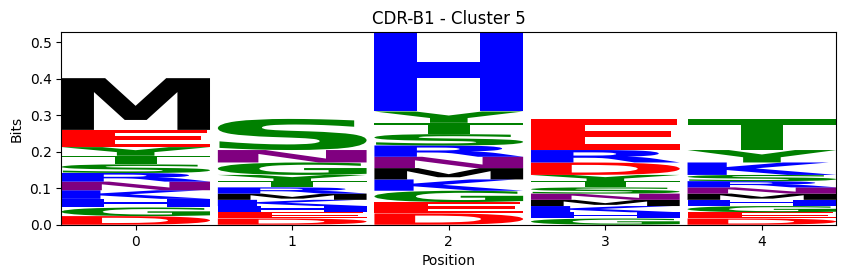

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


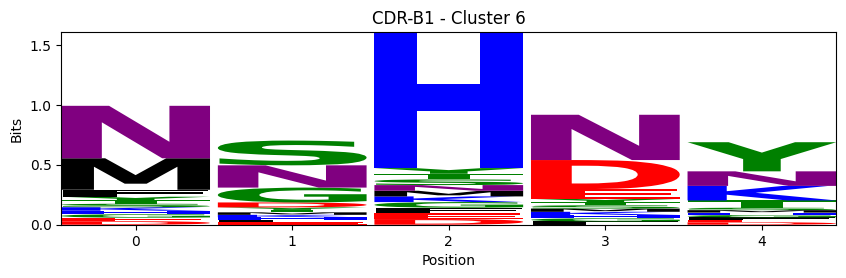

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


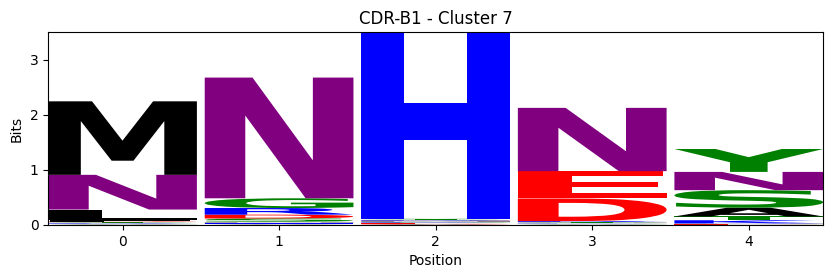

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


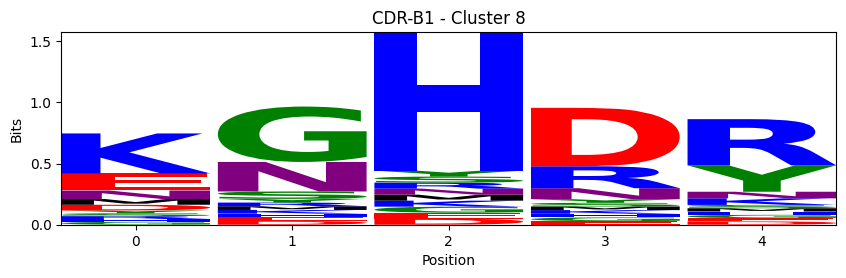

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


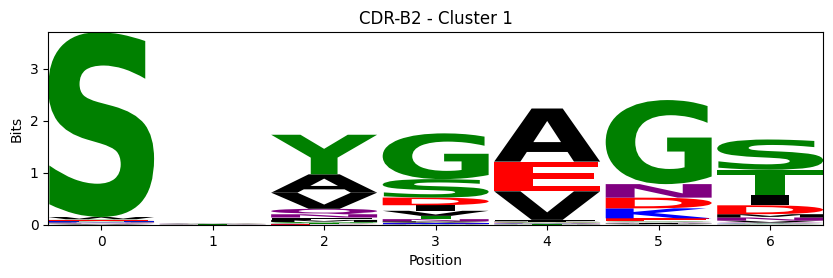

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


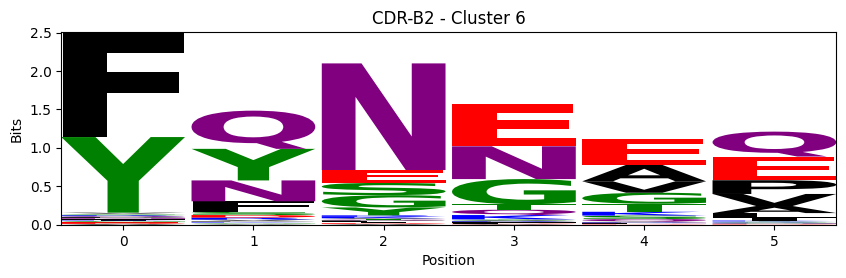

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


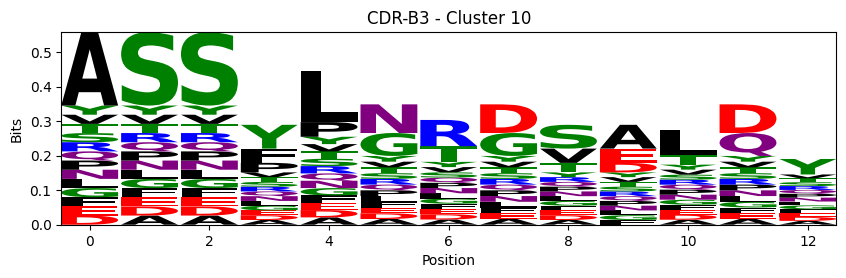

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


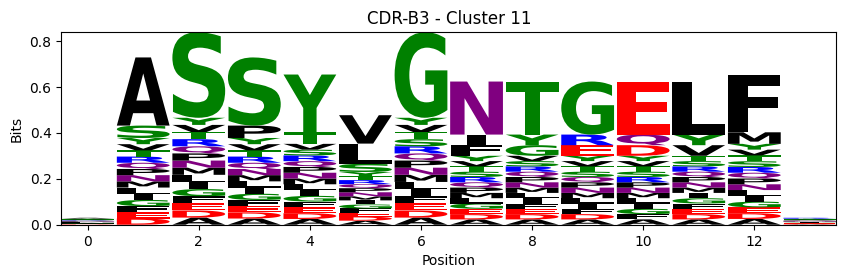

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


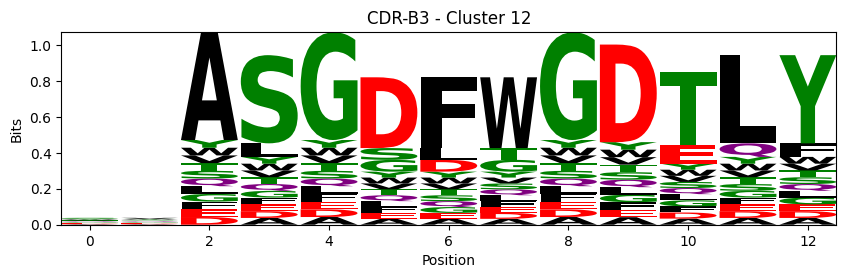

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


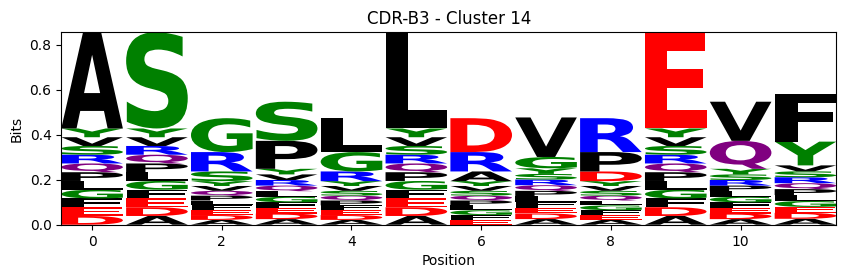

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


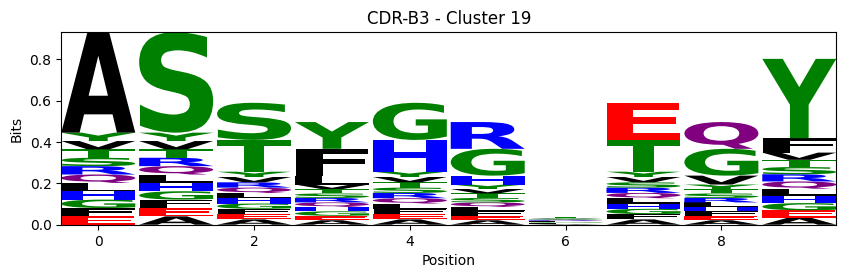

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


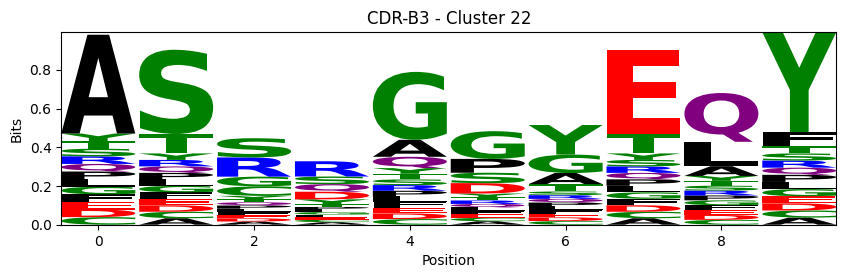

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


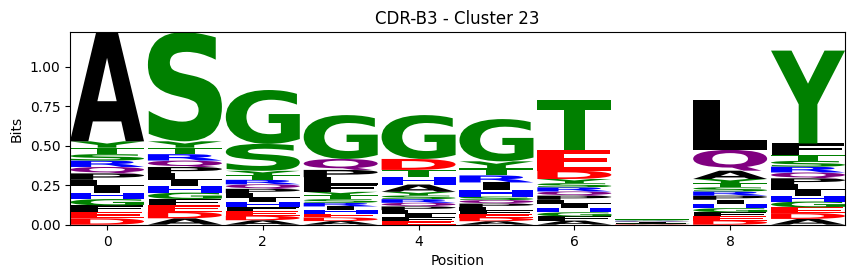

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


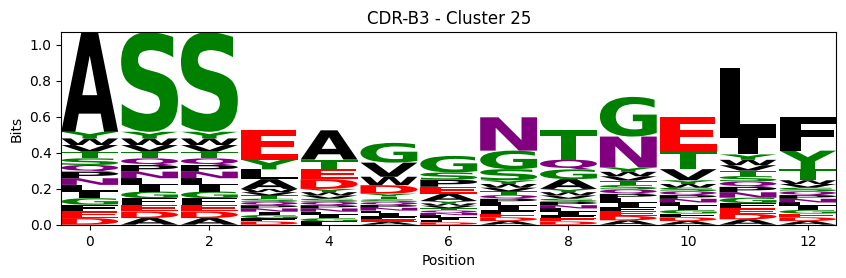

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


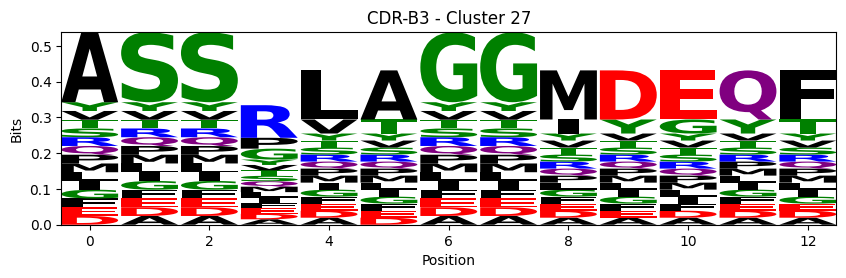

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


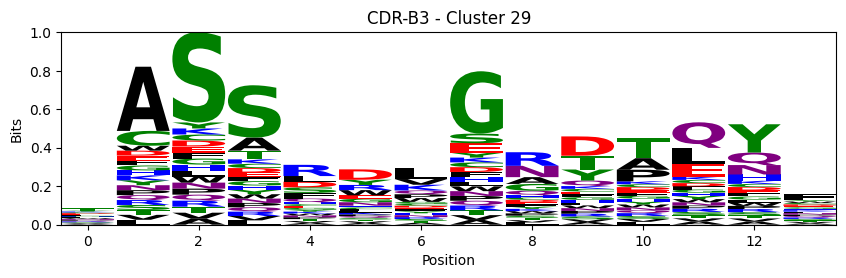

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


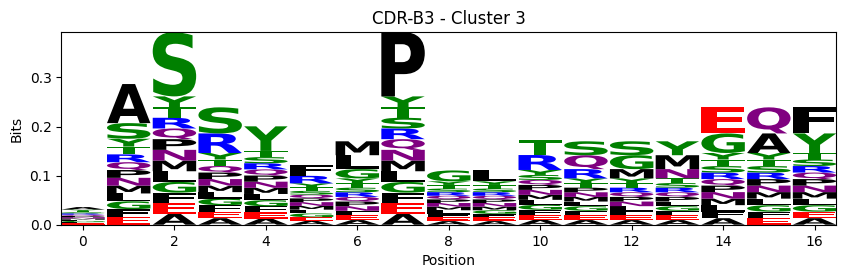

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


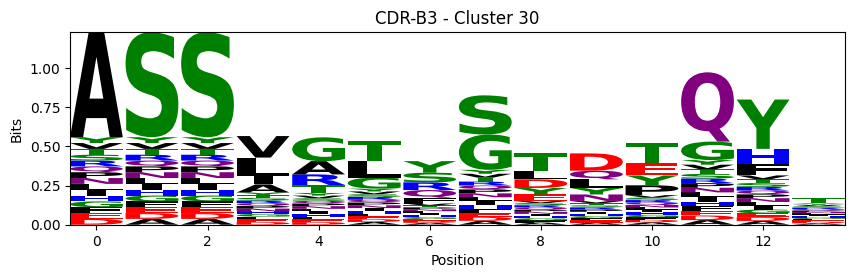

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


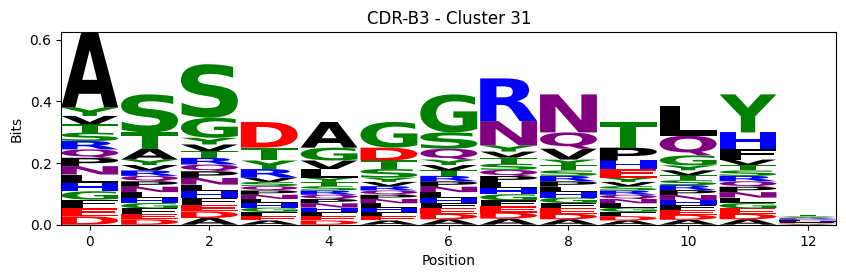

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


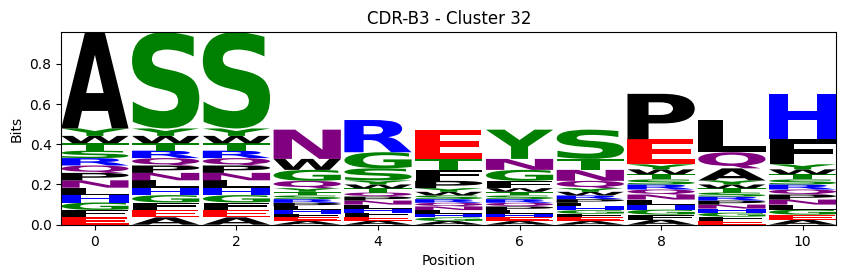

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


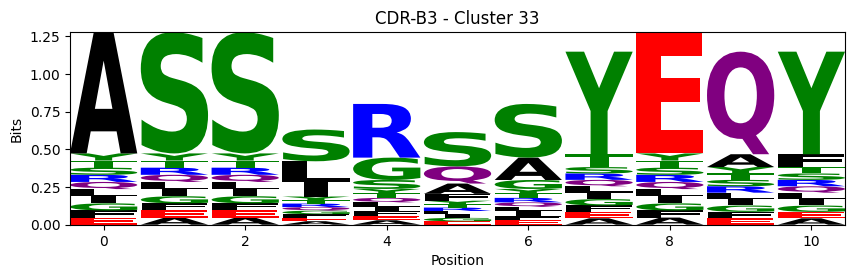

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


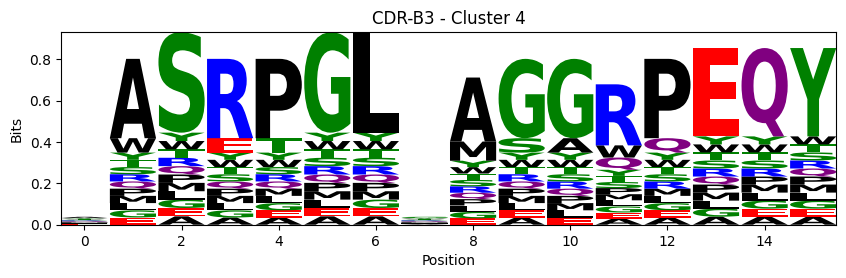

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


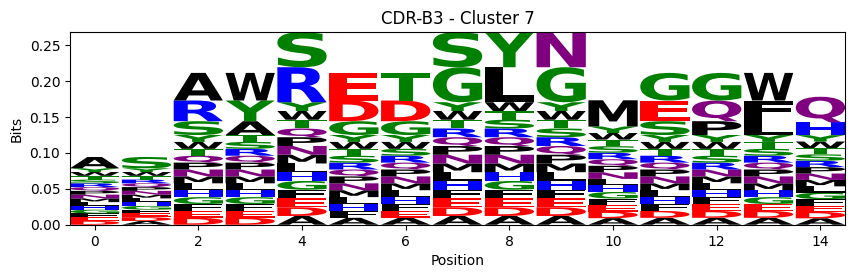

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


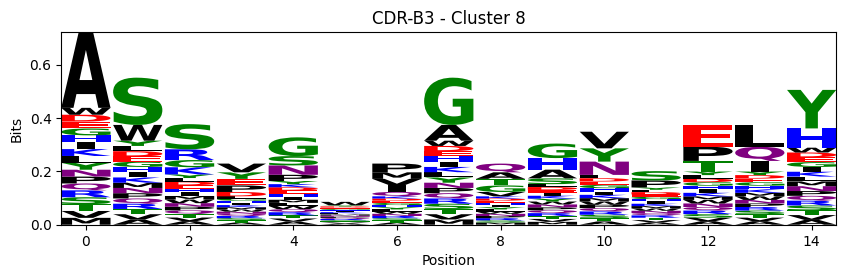

In [22]:
for (chain_type, cdr, cluster), group in df.query("cluster != 'noise' and cluster_type == 'canonical'").groupby(['chain_type', 'cdr', 'cluster']):
    with tempfile.TemporaryDirectory() as directory:
        input_file = os.path.join(directory, 'input.fasta')
        output_file = os.path.join(directory, 'output.fasta')

        with open(input_file, 'w') as fh:
            fh.write(format_fasta(group))

        cmd = f'clustalw2 -INFILE={input_file} -OUTFILE={output_file} -OUTPUT=FASTA'
        subprocess.run(cmd.split(), check=True, stdout=subprocess.DEVNULL)

        with open(output_file, 'r') as fh:
            aligned_sequences = [line.strip() for line in fh.readlines() if not line.startswith('>')]


    probs = logomaker.alignment_to_matrix(aligned_sequences, to_type='information')
    logomaker.Logo(probs, color_scheme='chemistry')
    
    plt.title(f"CDR-{'A' if chain_type == 'alpha_chain' else 'B'}{cdr} - Cluster {cluster}")
    plt.ylabel('Bits')
    plt.xlabel('Position')
    
    plt.show()

## Look at backbone traces of each cluster

In [23]:
ca_coordinates = []
names = []
chain_types = []
cdrs = []
clusters = []

for (chain_type, cdr, cluster), group in df.query("cluster != 'noise' and cluster_type == 'canonical'").groupby(['chain_type', 'cdr', 'cluster']):

    
    pdb_id, chains = group.iloc[0]['name'].split('_')
    alpha_chain_id, beta_chain_id = tuple(chains)
    cdr = int(cdr)

    with open(os.path.join('../data/raw/stcrdab', 'imgt', pdb_id + '.pdb'), 'r') as fh:
        reference_structure_df = parse_pdb_to_pandas(fh.read())

    reference_structure_df = annotate_tcr_pmhc_df(reference_structure_df, alpha_chain_id, beta_chain_id)
    reference_tcr_df = reference_structure_df.query('chain_type.notnull()')

    reference_cdr_df = reference_tcr_df.query(("chain_type == @chain_type and cdr == @cdr"))
    refrence_anchors = pd.concat(find_anchors(reference_cdr_df, reference_tcr_df, 5))

    for _, row in group.iterrows():
        pdb_id, chains = row['name'].split('_')
        alpha_chain_id, beta_chain_id = tuple(chains)

        chain_type = row.chain_type
        cdr = int(row.cdr)

        with open(os.path.join('../data/raw/stcrdab', 'imgt', pdb_id + '.pdb'), 'r') as fh:
            structure_df = parse_pdb_to_pandas(fh.read())

        structure_df = annotate_tcr_pmhc_df(structure_df, alpha_chain_id, beta_chain_id)
        tcr_df = structure_df.query('chain_type.notnull()')

        cdr_df = tcr_df.query(("chain_type == @chain_type and cdr == @cdr"))
        anchors = pd.concat(find_anchors(cdr_df, tcr_df, 5))

        cdr_df = align_pandas_structure(get_coords(anchors.query("atom_name == 'N' or atom_name == 'C' or atom_name == 'CA' or atom_name == 'O'")),
                                        get_coords(refrence_anchors.query("atom_name == 'N' or atom_name == 'C' or atom_name == 'CA' or atom_name == 'O'")),
                                        cdr_df)

        coords = get_coords(cdr_df.query("atom_name == 'CA'"))
        
        ca_coordinates.append(coords)
        chain_types.append(chain_type)
        cdrs.append(cdr)
        clusters.append(cluster)
        names.append(row['name'])

ca_coordinate_df = pd.DataFrame({
    'ca_coordinate': ca_coordinates,
    'chain_type': chain_types,
    'cdr': cdrs,
    'name': names,
    'cluster': clusters,
})

ca_coordinate_df = ca_coordinate_df.explode('ca_coordinate')
ca_coordinate_df[['ca_coordinate_x',
                  'ca_coordinate_y',
                  'ca_coordinate_z']] = ca_coordinate_df['ca_coordinate'].apply(pd.Series)
ca_coordinate_df = ca_coordinate_df.drop('ca_coordinate', axis=1)
ca_coordinate_df

chain_type  cdr     name cluster  ca_coordinate_x  ca_coordinate_y  \
0     alpha_chain    1  8gom_DE       1        -4.707000       -41.505000   
0     alpha_chain    1  8gom_DE       1        -6.362000       -41.487000   
0     alpha_chain    1  8gom_DE       1        -3.087000       -41.359000   
0     alpha_chain    1  8gom_DE       1        -0.982000       -38.619000   
0     alpha_chain    1  8gom_DE       1         2.246000       -40.656000   
...           ...  ...      ...     ...              ...              ...   
2771   beta_chain    3  5e9d_DE       8        14.318244        36.557544   
2771   beta_chain    3  5e9d_DE       8        13.679889        33.773549   
2771   beta_chain    3  5e9d_DE       8        11.163317        34.765088   
2771   beta_chain    3  5e9d_DE       8         7.533356        34.743422   
2771   beta_chain    3  5e9d_DE       8         5.596954        37.809503   

      ca_coordinate_z  
0           -3.483000  
0           -0.060000  
0            1.865000  
0            3.427000  
0            3.483000  
...               ...  
2771        24.442150  
2771        26.939227  
2771        29.624675  
2771        28.513019  
2771        29.639868  

[19019 rows x 7 columns]

In [24]:
ca_coordinate_df['cluster_name'] = (
    'CDR-'
    + ca_coordinate_df['chain_type'].map(lambda chain_type: 'A' if chain_type == 'alpha_chain' else 'B')
    + ca_coordinate_df['cdr'].apply(str)
    + ' - Cluster '
    + ca_coordinate_df['cluster']
)

In [25]:
for cluster_name, cluster_df in ca_coordinate_df.groupby('cluster_name'):
    fig = px.line_3d()

    cluster_df = ca_coordinate_df.query('cluster_name == @cluster_name')
    for _, cdr_loop in cluster_df.groupby('name'):
        fig.add_scatter3d(x=cdr_loop['ca_coordinate_x'],
                          y=cdr_loop['ca_coordinate_y'],
                          z=cdr_loop['ca_coordinate_z'],
                          mode='lines',
                          line=dict(color='green'),
                          showlegend=False)

    fig.update_layout(title=cluster_name)
    fig.write_html(f"../report/figures/cdr-loop-clusters/{cluster_name}.html")

In [26]:
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)

        dropdown = Dropdown(options=cluster_names, description='Select Cluster')
        dropdown.observe(on_change)
        display(VBox([dropdown]))

        plot_cluster(change['new'])

def plot_cluster(cluster_name):
    fig = px.line_3d()

    cluster_df = ca_coordinate_df.query('cluster_name == @cluster_name')
    for _, cdr_loop in cluster_df.groupby('name'):
        fig.add_scatter3d(x=cdr_loop['ca_coordinate_x'],
                          y=cdr_loop['ca_coordinate_y'],
                          z=cdr_loop['ca_coordinate_z'],
                          mode='lines',
                          line=dict(color='green'),
                          showlegend=False)

    fig.update_layout(title=cluster_name)
    fig.show()

cluster_names = ca_coordinate_df['cluster_name'].unique().tolist()

dropdown = Dropdown(options=cluster_names, description='Select Cluster')
dropdown.observe(on_change)
display(VBox([dropdown]))

plot_cluster(cluster_names[0])

# Compare *apo* and *holo* forms of loops

In [27]:
apo_holo_summary_df = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I/apo_holo_summary.csv')
apo_holo_summary_df

file_name pdb_id structure_type state alpha_chain  \
0    1ao7_D-E-C-A-B_tcr_pmhc.pdb   1ao7       tcr_pmhc  holo           D   
1    1bd2_D-E-C-A-B_tcr_pmhc.pdb   1bd2       tcr_pmhc  holo           D   
2            1bii_A-B-P_pmhc.pdb   1bii           pmhc   apo         NaN   
3            1ddh_A-B-P_pmhc.pdb   1ddh           pmhc   apo         NaN   
4            1duz_A-B-C_pmhc.pdb   1duz           pmhc   apo         NaN   
..                           ...    ...            ...   ...         ...   
353  8gon_D-E-C-A-B_tcr_pmhc.pdb   8gon       tcr_pmhc  holo           D   
354             8gop_A-B_tcr.pdb   8gop            tcr   apo           A   
355  8gvb_A-B-P-H-L_tcr_pmhc.pdb   8gvb       tcr_pmhc  holo           A   
356  8gvg_A-B-P-H-L_tcr_pmhc.pdb   8gvg       tcr_pmhc  holo           A   
357  8gvi_A-B-P-H-L_tcr_pmhc.pdb   8gvi       tcr_pmhc  holo           A   

    beta_chain antigen_chain mhc_chain1 mhc_chain2  \
0            E             C          A          B   
1            E             C          A          B   
2          NaN             P          A          B   
3          NaN             P          A          B   
4          NaN             C          A          B   
..         ...           ...        ...        ...   
353          E             C          A          B   
354          B           NaN        NaN        NaN   
355          B             P          H          L   
356          B             P          H          L   
357          B             P          H          L   

                                cdr_sequences_collated peptide_sequence  \
0    DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLA...        LLFGYPVYV   
1    NSMFDY-ISSIKDK-AAMEGAQKLV-MNHEY-SVGAGI-ASSYPGG...        LLFGYPVYV   
2                                                  NaN       RGPGRAFVTI   
3                                                  NaN       RGPGRAFVTI   
4                                                  NaN        LLFGYPVYV   
..                                                 ...              ...   
353  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...              NaN   
354  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...              NaN   
355  YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...         RYPLTFGW   
356  YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...         RFPLTFGW   
357  YGATPY-YFSGDTLV-AVVFTGGGNKLT-SEHNR-FQNEAQ-ASSL...         RYPLTFGW   

        mhc_slug  
0    hla_a_02_01  
1    hla_a_02_01  
2          h2_dd  
3          h2_dd  
4    hla_a_02_01  
..           ...  
353          NaN  
354          NaN  
355  hla_a_24_02  
356  hla_a_24_02  
357  hla_a_24_02  

[358 rows x 12 columns]

In [28]:
df[['pdb_id', 'chains']] = df['name'].str.split('_').apply(pd.Series)
df[['alpha_chain', 'beta_chain']] = df['chains'].apply(list).apply(pd.Series)

In [29]:
apo_holo_clusters = df.merge(apo_holo_summary_df,
                             how='inner',
                             on=['pdb_id', 'alpha_chain', 'beta_chain'])
apo_holo_clusters

name cluster     umap_1     umap_2   chain_type cdr       sequence  \
0     8gom_DE       6  -5.183248   0.462702   beta_chain   2         FNNNVP   
1     8gom_DE       2   4.715413  20.277153   beta_chain   1          SGHNS   
2     8gom_DE   noise   7.066840   7.239445   beta_chain   3  ASTWGRASTDTQY   
3     8gom_DE       1  -1.801840  -7.064035  alpha_chain   1        TSESDYY   
4     8gom_DE       3   4.826867  -4.096010  alpha_chain   2       QEAYKQQN   
...       ...     ...        ...        ...          ...  ..            ...   
1189  3dxa_NO       2   5.255575  23.470249   beta_chain   1          SEHNR   
1190  3dxa_NO   noise   8.677380  -0.234534   beta_chain   3  ASRYRDDSYNEQF   
1191  3dxa_NO       2  11.237581  -3.133538  alpha_chain   1        TISGNEY   
1192  3dxa_NO   noise -10.087424   3.657393  alpha_chain   2          GLKNN   
1193  3dxa_NO      12   4.313787   1.763012  alpha_chain   3     IVWGGYQKVT   

     cluster_type  cdr_length pdb_id  ... beta_chain  \
0       canonical           6   8gom  ...          E   
1       canonical           5   8gom  ...          E   
2             NaN          13   8gom  ...          E   
3       canonical           7   8gom  ...          E   
4       canonical           8   8gom  ...          E   
...           ...         ...    ...  ...        ...   
1189    canonical           5   3dxa  ...          O   
1190          NaN          13   3dxa  ...          O   
1191    canonical           7   3dxa  ...          O   
1192          NaN           5   3dxa  ...          O   
1193    canonical          10   3dxa  ...          O   

                        file_name structure_type state antigen_chain  \
0     8gom_D-E-C-A-B_tcr_pmhc.pdb       tcr_pmhc  holo             C   
1     8gom_D-E-C-A-B_tcr_pmhc.pdb       tcr_pmhc  holo             C   
2     8gom_D-E-C-A-B_tcr_pmhc.pdb       tcr_pmhc  holo             C   
3     8gom_D-E-C-A-B_tcr_pmhc.pdb       tcr_pmhc  holo             C   
4     8gom_D-E-C-A-B_tcr_pmhc.pdb       tcr_pmhc  holo             C   
...                           ...            ...   ...           ...   
1189  3dxa_N-O-M-K-L_tcr_pmhc.pdb       tcr_pmhc  holo             M   
1190  3dxa_N-O-M-K-L_tcr_pmhc.pdb       tcr_pmhc  holo             M   
1191  3dxa_N-O-M-K-L_tcr_pmhc.pdb       tcr_pmhc  holo             M   
1192  3dxa_N-O-M-K-L_tcr_pmhc.pdb       tcr_pmhc  holo             M   
1193  3dxa_N-O-M-K-L_tcr_pmhc.pdb       tcr_pmhc  holo             M   

     mhc_chain1 mhc_chain2                             cdr_sequences_collated  \
0             A          B  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...   
1             A          B  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...   
2             A          B  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...   
3             A          B  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...   
4             A          B  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...   
...         ...        ...                                                ...   
1189          K          L  TISGNEY-GLKNN-IVWGGYQKVT-SEHNR-FQNEAQ-ASRYRDDS...   
1190          K          L  TISGNEY-GLKNN-IVWGGYQKVT-SEHNR-FQNEAQ-ASRYRDDS...   
1191          K          L  TISGNEY-GLKNN-IVWGGYQKVT-SEHNR-FQNEAQ-ASRYRDDS...   
1192          K          L  TISGNEY-GLKNN-IVWGGYQKVT-SEHNR-FQNEAQ-ASRYRDDS...   
1193          K          L  TISGNEY-GLKNN-IVWGGYQKVT-SEHNR-FQNEAQ-ASRYRDDS...   

     peptide_sequence mhc_slug  
0                 NaN      NaN  
1                 NaN      NaN  
2                 NaN      NaN  
3                 NaN      NaN  
4                 NaN      NaN  
...               ...      ...  
1189              NaN      NaN  
1190              NaN      NaN  
1191              NaN      NaN  
1192              NaN      NaN  
1193              NaN      NaN  

[1194 rows x 22 columns]

In [30]:
def collate_clusters(group):
    apo_clusters = sorted(group.query("state == 'apo'")['cluster'].tolist())
    holo_clusters = sorted(group.query("state == 'holo'")['cluster'].tolist())

    return pd.Series({'apo_clusters': apo_clusters, 'holo_clusters': holo_clusters})

apo_holo_clusters_agg = apo_holo_clusters.groupby(['cdr_sequences_collated', 'chain_type', 'cdr']).apply(collate_clusters).reset_index()
apo_holo_clusters_agg

cdr_sequences_collated   chain_type cdr  \
0    ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
1    ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   2   
2    ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   3   
3    ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...   beta_chain   1   
4    ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...   beta_chain   2   
..                                                 ...          ...  ..   
385  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...  alpha_chain   2   
386  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...  alpha_chain   3   
387  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   1   
388  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   2   
389  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   

    apo_clusters   holo_clusters  
0           [19]  [noise, noise]  
1        [noise]     [10, noise]  
2           [11]  [noise, noise]  
3            [2]          [2, 2]  
4            [6]          [6, 6]  
..           ...             ...  
385      [noise]         [noise]  
386      [noise]         [noise]  
387          [2]             [2]  
388          [6]             [6]  
389      [noise]         [noise]  

[390 rows x 5 columns]

Types of movements:

| *apo* |   | *holo* | name |
| ----- | - | ------ | ---- |
| noise | → | noise | noise|
| noise | → | canonical cluster | noise2canonical_cluster |
| noise | → | pseudo cluster | noise2pseudo_cluster |
| canonical cluster | → | noise | canonical_cluster2noise |
| pseudo cluster | → | noise | pseudo_cluster2noise |
| canonical cluster | → | *different* canonical cluster | canonical_cluster_shift |
| pseudo cluster | → | *different* pseudo cluster | pseudo_cluster_shift |
| canonical cluster | → | pseudo cluster | canonical2pseudo |
| pseudo cluster | → | canonical cluster | pseudo2canonical |
| canonical cluster | → | *same* canonical cluster | canonical_cluster_same |
| pseudo cluster | → | *same* pseudo cluster | pseudo_cluster_same |


In [31]:
def classify_movement(chain_type: str, cdr: str, apo_clusters: list[str], holo_clusters: list[str], cluster_types: pd.Series) -> pd.Series:
    types = {
        'noise': 0,
        'noise2canonical_cluster': 0,
        'noise2pseudo_cluster': 0,
        'canonical_cluster2noise': 0,
        'pseudo_cluster2noise': 0,
        'canonical_cluster_shift': 0,
        'pseudo_cluster_shift': 0,
        'canonical2pseudo': 0,
        'pseudo2canonical': 0,
        'canonical_cluster_same': 0,
        'pseudo_cluster_same': 0,
    }
    
    for apo_clust, holo_clust in itertools.product(apo_clusters, holo_clusters):
        if apo_clust == 'noise' and holo_clust == 'noise':
            types['noise'] += 1
        
        elif apo_clust == 'noise' and holo_clust != 'noise':
            if cluster_types.loc[chain_type, cdr, holo_clust] == 'canonical':
                 types['noise2canonical_cluster'] += 1
            
            else:
                types['noise2pseudo_cluster'] += 1
        
        elif apo_clust != 'noise' and holo_clust == 'noise':
            if cluster_types.loc[chain_type, cdr, apo_clust] == 'canonical':
                 types['canonical_cluster2noise'] += 1
            
            else:
                types['pseudo_cluster2noise'] += 1
        
        elif apo_clust != holo_clust:
            if cluster_types.loc[chain_type, cdr, apo_clust] == cluster_types.loc[chain_type, cdr, holo_clust] == 'canonical':
                 types['canonical_cluster_shift'] += 1
            
            elif cluster_types.loc[chain_type, cdr, apo_clust] == 'canonical' and cluster_types.loc[chain_type, cdr, holo_clust] == 'pseudo':
                types['canonical2pseudo'] += 1
            
            else:
                types['pseudo2canonical'] += 1
        
        elif apo_clust == holo_clust:
            if cluster_types.loc[chain_type, cdr, apo_clust] == 'canonical':
                types['canonical_cluster_same'] += 1

            else:
                types['pseudo_cluster_same'] += 1
        
    return pd.Series(types)


apo_holo_clusters_agg = apo_holo_clusters_agg.join(apo_holo_clusters_agg.apply(
    lambda row: classify_movement(row.chain_type, row.cdr, row.apo_clusters, row.holo_clusters, cluster_types), axis=1
))

# Wide to long
apo_holo_clusters_agg = apo_holo_clusters_agg.melt(id_vars=['cdr_sequences_collated', 'chain_type', 'cdr'],
                                                 value_vars=['noise',
                                                             'noise2canonical_cluster',
                                                             'noise2pseudo_cluster',
                                                             'canonical_cluster2noise',
                                                             'pseudo_cluster2noise',
                                                             'canonical_cluster_shift',
                                                             'pseudo_cluster_shift',
                                                             'canonical2pseudo',
                                                             'pseudo2canonical',
                                                             'canonical_cluster_same',
                                                             'pseudo_cluster_same'],
                                                 var_name='types', value_name='count')

# Normalize for differeing group sizes
apo_holo_clusters_agg = apo_holo_clusters_agg.groupby(['cdr_sequences_collated', 'chain_type', 'cdr', 'types'])['count'].median().reset_index()
apo_holo_clusters_agg

cdr_sequences_collated   chain_type cdr  \
0     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
1     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
2     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
3     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
4     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
...                                                 ...          ...  ..   
4285  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4286  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4287  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4288  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4289  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   

                        types  count  
0            canonical2pseudo    0.0  
1     canonical_cluster2noise    2.0  
2      canonical_cluster_same    0.0  
3     canonical_cluster_shift    0.0  
4                       noise    0.0  
...                       ...    ...  
4285     noise2pseudo_cluster    0.0  
4286         pseudo2canonical    0.0  
4287     pseudo_cluster2noise    0.0  
4288      pseudo_cluster_same    0.0  
4289     pseudo_cluster_shift    0.0  

[4290 rows x 5 columns]

In [32]:
apo_holo_clusters_agg

cdr_sequences_collated   chain_type cdr  \
0     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
1     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
2     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
3     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
4     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
...                                                 ...          ...  ..   
4285  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4286  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4287  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4288  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4289  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   

                        types  count  
0            canonical2pseudo    0.0  
1     canonical_cluster2noise    2.0  
2      canonical_cluster_same    0.0  
3     canonical_cluster_shift    0.0  
4                       noise    0.0  
...                       ...    ...  
4285     noise2pseudo_cluster    0.0  
4286         pseudo2canonical    0.0  
4287     pseudo_cluster2noise    0.0  
4288      pseudo_cluster_same    0.0  
4289     pseudo_cluster_shift    0.0  

[4290 rows x 5 columns]

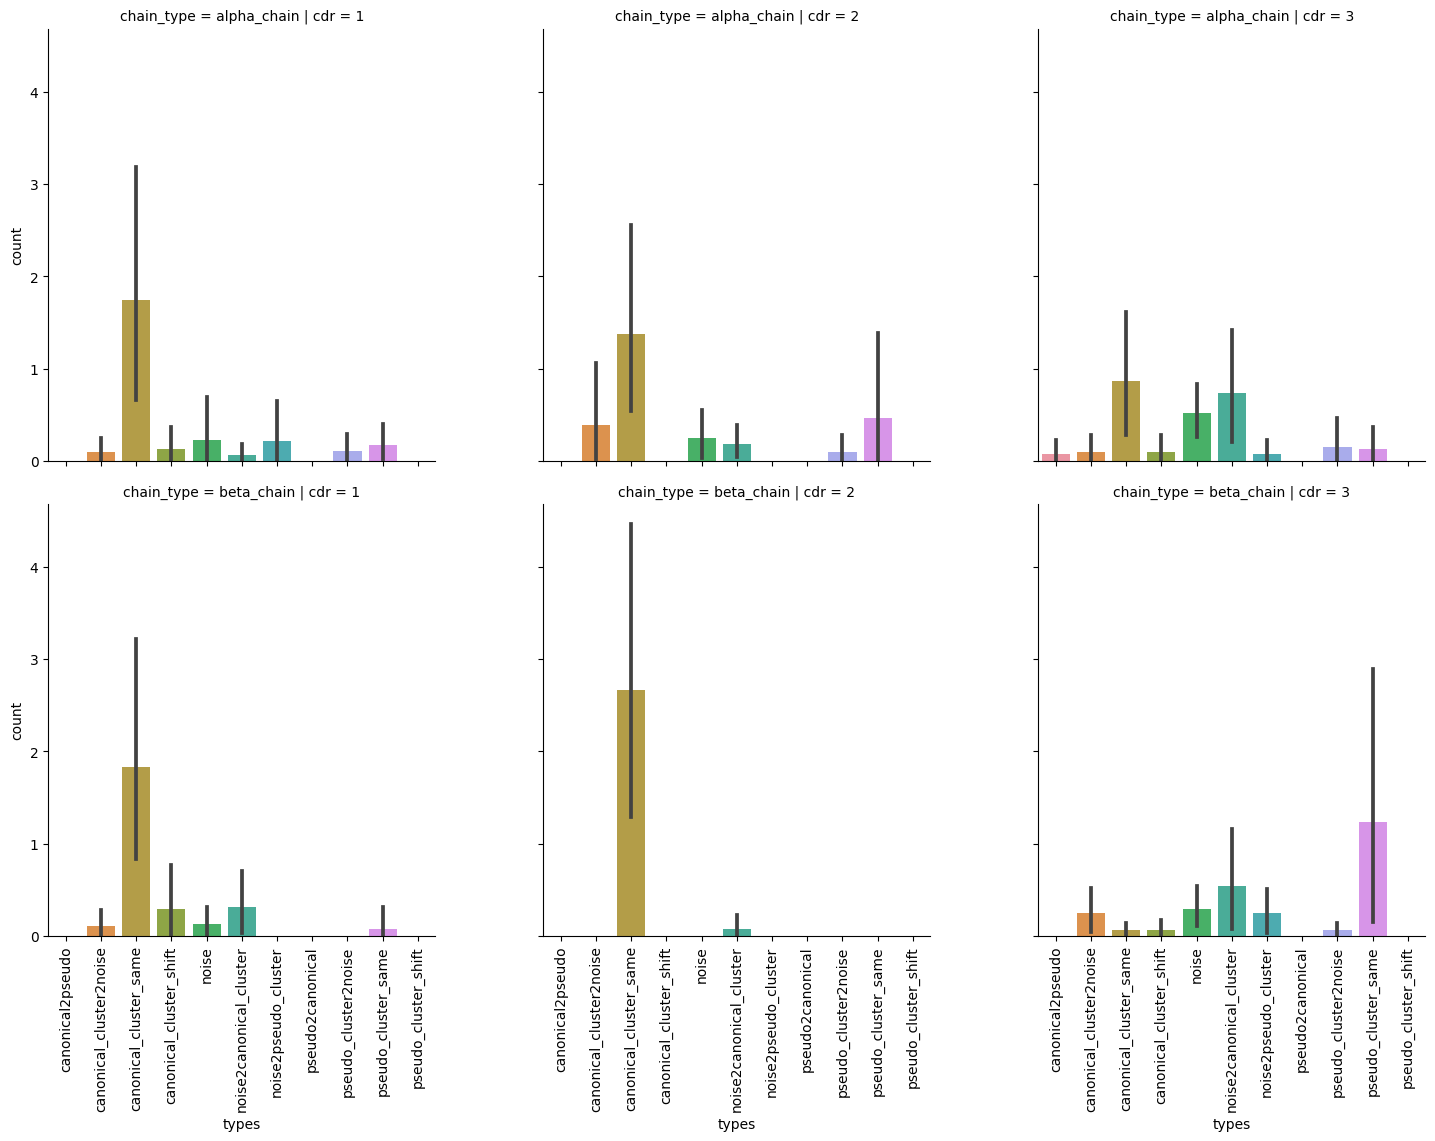

In [33]:
g = sns.catplot(apo_holo_clusters_agg.sort_values(['chain_type', 'cdr', 'types']),
                row='chain_type', col='cdr',
                x='types', y='count',
                kind='bar')

for ax in g.axes.flat:
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=90)

In [34]:
cluster_shift_counts = apo_holo_clusters_agg.groupby(['chain_type', 'cdr', 'types'])['count'].sum().astype(int)
cluster_shift_counts[cluster_shift_counts > 0]

chain_type   cdr  types                  
alpha_chain  1    canonical_cluster2noise      6
                  canonical_cluster_same     113
                  canonical_cluster_shift      8
                  noise                       15
                  noise2canonical_cluster      4
                  noise2pseudo_cluster        14
                  pseudo_cluster2noise         7
                  pseudo_cluster_same         11
             2    canonical_cluster2noise     25
                  canonical_cluster_same      89
                  noise                       16
                  noise2canonical_cluster     12
                  pseudo_cluster2noise         6
                  pseudo_cluster_same         30
             3    canonical2pseudo             5
                  canonical_cluster2noise      6
                  canonical_cluster_same      56
                  canonical_cluster_shift      6
                  noise                       34
                  noise2can